In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
import os

In [6]:
img_files = os.listdir("pdf2png")

In [7]:
img = cv2.imread("pdf2png/ZUG-GU22_01_IST_20140922-1.png", 0)

In [8]:
img_file = img_files[0]

In [9]:
img2 = img[600:1700,200:3400]

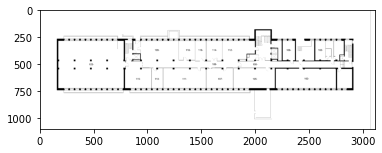

In [10]:
plt.imshow(np.where(img2 > 200, 255, 0), cmap="gray")

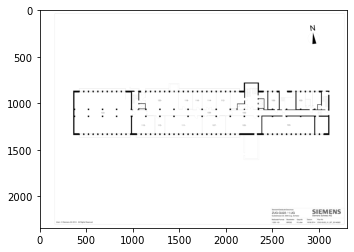

In [11]:
plt.imshow(img, cmap="gray")

In [12]:
img2.shape

(1100, 3109)

In [13]:
img3 = np.where(img2 > 200, 255, 0)

In [14]:
a,b = np.where(img2 <=100)

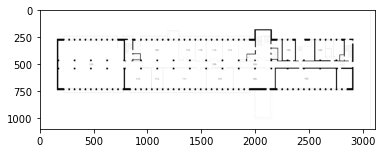

In [15]:
plt.imshow(img2, cmap="gray")

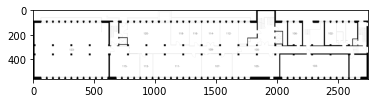

In [16]:
img_cropped = img2[min(a):max(a),min(b):max(b)]
plt.imshow(img_cropped, cmap="gray")

In [17]:
# plt.hist(img2.flatten(), bins=256, range=(0,200))

In [18]:
img_cropped.shape

(562, 2751)

In [21]:
a = np.array([1,2,3,4,5,6,7,8,9,10,0,0,0])

In [20]:
for c,b in zip(a[:-1], a[1:]):
    print(c-b)

-1
-1
-1
-1
-1
-1
-1
-1
-1


In [23]:
np.argwhere(a).reshape(-1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
def get_door(img, corners, door_length_thres = 400, door_width_thres = 400):
    
    plt.figure(figsize=(50,20))
    plt.imshow(img , cmap="gray")
    img_new = np.zeros_like(img).astype(np.uint8)
    doors = []
    for y, row in enumerate(corners):
        x_same_y = np.argwhere(row).reshape(-1)
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):
            try:
                if x2 - x1 < door_length_thres:
                    doors.append(((x2,x1,),y))
                    color = np.array([255,255,255])
                    cv2.line(img_new, (x1, y), (x2, y), color, 2).astype(np.uint8)
                    print("works")
                    print(x2-x1)
                    
            except:
                pass
                # print(x1,x2)
    for x, col in enumerate(corners.T):
        y_same_x = np.argwhere(col).reshape(-1)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            try:
                if y2 - y1 < door_length_thres:
                    doors.append((x,(y2,y1,)))
                    
                    color = np.array([255,0,0])
                    cv2.line(img_new, (x, y1), (x, y2), color, 2).astype(np.uint8)
                    print("works")
                    print(y2-y1)
                    
            except:
                pass
                # print(y1,y2)
    plt.figure(figsize=(50,20))
    plt.imshow(img_new ,)
    return doors


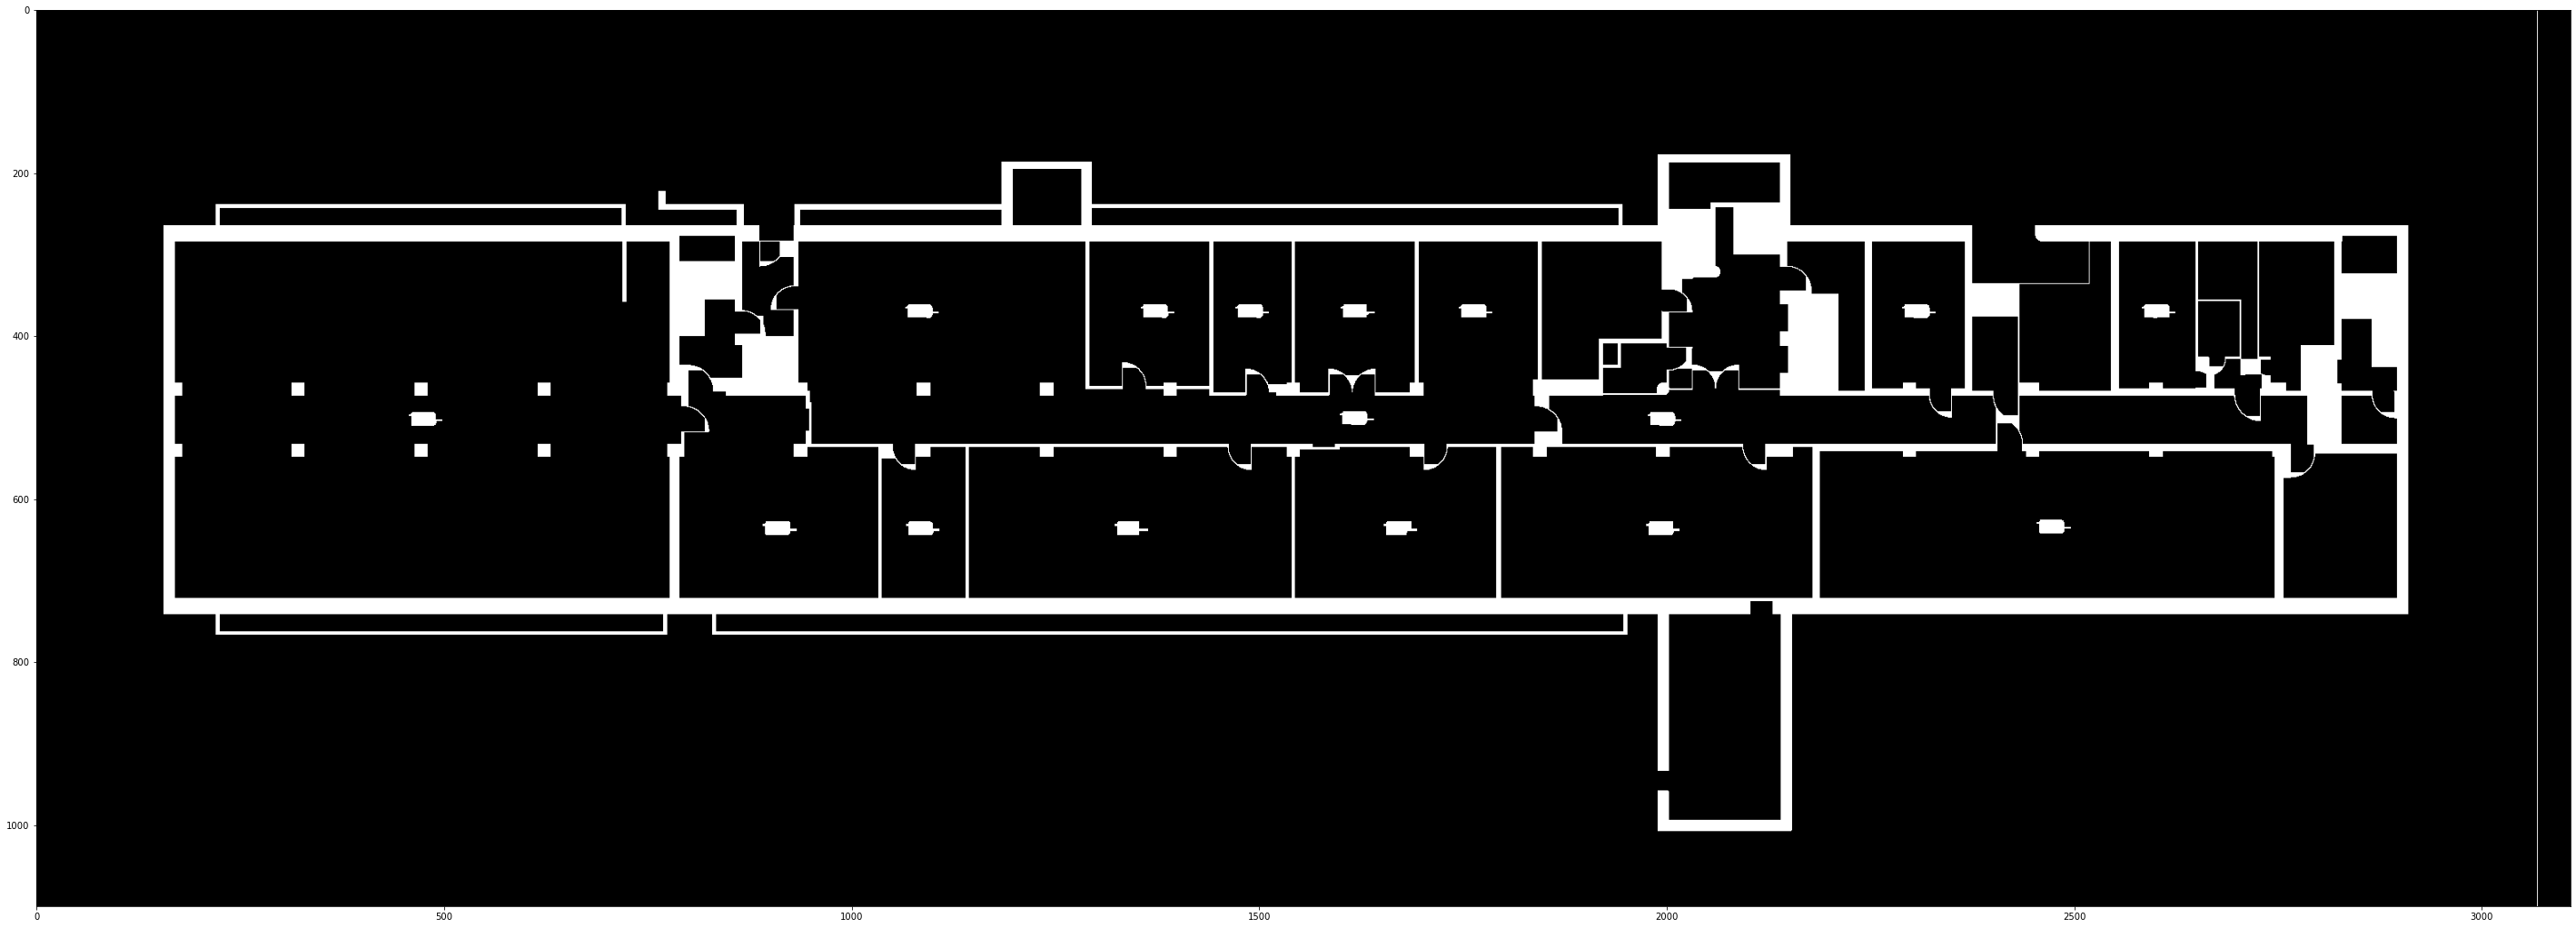

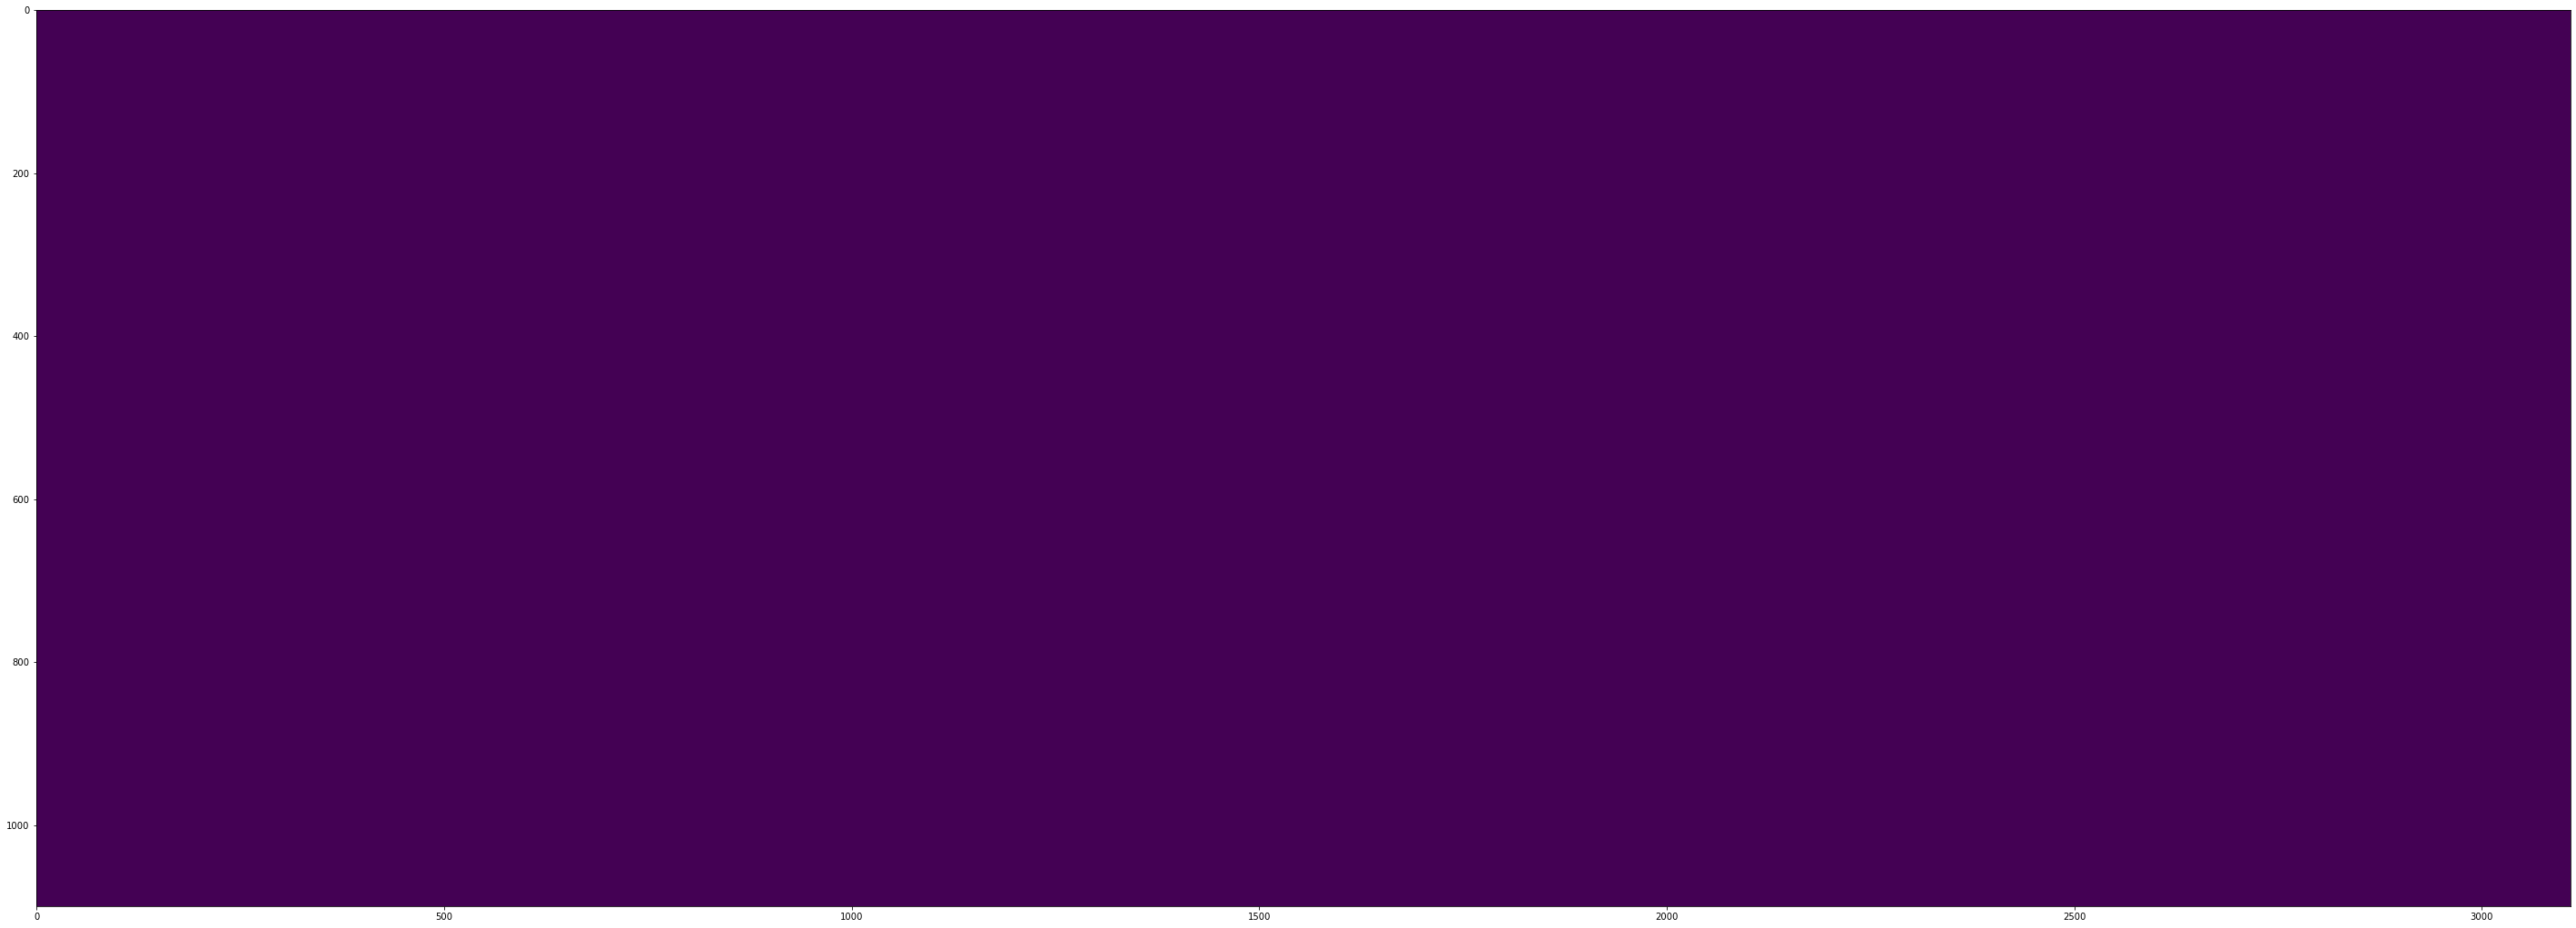

In [43]:
d = get_door(img.astype(np.int8), corners)

In [38]:
np.argwhere(row)

array([[3068],
       [3069]])

ValueError: not enough values to unpack (expected 2, got 1)

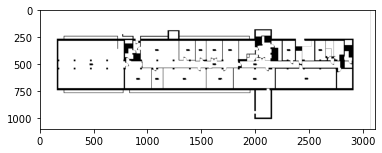

In [45]:
plt.imshow(img, cmap="gray")

In [39]:

for y, row in enumerate(corners):
    x_same_y = np.argwhere(row).reshape(-1)
    for x1,x2 in zip(x_same_y[:-1],x_same_y[1:]):
        if x2 - x1 < 400 and x2-x1>50:
            print(x2-x1)
            print(x1,x2)

159
1991 2150
159
1991 2150
159
1991 2150
163
1989 2152
163
1989 2152
163
1989 2152
163
1989 2152
163
1989 2152
107
1186 1293
163
1989 2152
132
2005 2137
107
1186 1293
107
1186 1293
132
2005 2137
111
1184 1295
132
2005 2137
111
1184 1295
136
2003 2139
111
1184 1295
136
2003 2139
111
1184 1295
136
2003 2139
111
1184 1295
136
2003 2139
80
1200 1280
136
2003 2139
136
2003 2139
80
1200 1280
136
2003 2139
80
1200 1280
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84
1198 1282
136
2003 2139
84

In [40]:
def cornerHarris(img_file, show = True,erode = False, corner_thres = 0.4, mid_show=True):
    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop = img[600:1700,200:3400]
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")
    img_gen_crop = np.where(img_gen_crop > 250, 255, 0).astype(np.uint8)

    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")
    img_gen_crop = cv2.erode(img_gen_crop,np.ones((3,3)), iterations=8)
    img_gen_crop = cv2.dilate(img_gen_crop,np.ones((3,3)), iterations=8)
    img_cropped = np.stack((img_gen_crop,)*3, axis=-1)
    dst = cv2.cornerHarris(img_gen_crop,2,3,0.04)
    dst = cv2.dilate(dst,None)
    a, b = np.where(dst>corner_thres*dst.max())
    return_dst = 1
    if return_dst:
        return dst, img_gen_crop
    doors = get_door(img, dst, door_length_thres = 100, door_width_thres = 100)
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_cropped, )
        plt.scatter(b,a , c="r", s=5)
    b_min = min(b)
    a_req_min = np.min(np.where(dst[:,b_min]>corner_thres*dst[:,b_min].max()))
    b_max = max(b)
    a_req_max = np.max(np.where(dst[:,b_max]>corner_thres*dst[:,b_max].max()))
    img_gen_crop = ~img_gen_crop
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_gen_crop, connectivity=4)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")
    print(sizes)
        
    # minimum size of particles we want to keep (number of pixels)
    #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = 200

    #your answer image
    img2 = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    img2 = img2.astype(np.uint8)

    

    if not erode:
        if show:
            plt.figure(figsize=(50,20))
            plt.imshow(img2, cmap="gray")
            print("HI")
        else:
            plt.imsave("dilated/harris/del_middle_"+img_file,img2)
        return ~img2
    else: 
        img_cropped = cv2.erode(img_cropped,np.ones((4,4)), iterations=3)
        if show:
            plt.imshow(img_cropped)
        else:
            plt.imsave("dilated/harris/del_"+img_file,img_cropped,) #cmap=plt.cm.gray)
        return img_cropped
    

In [41]:
img_file = img_files[2]

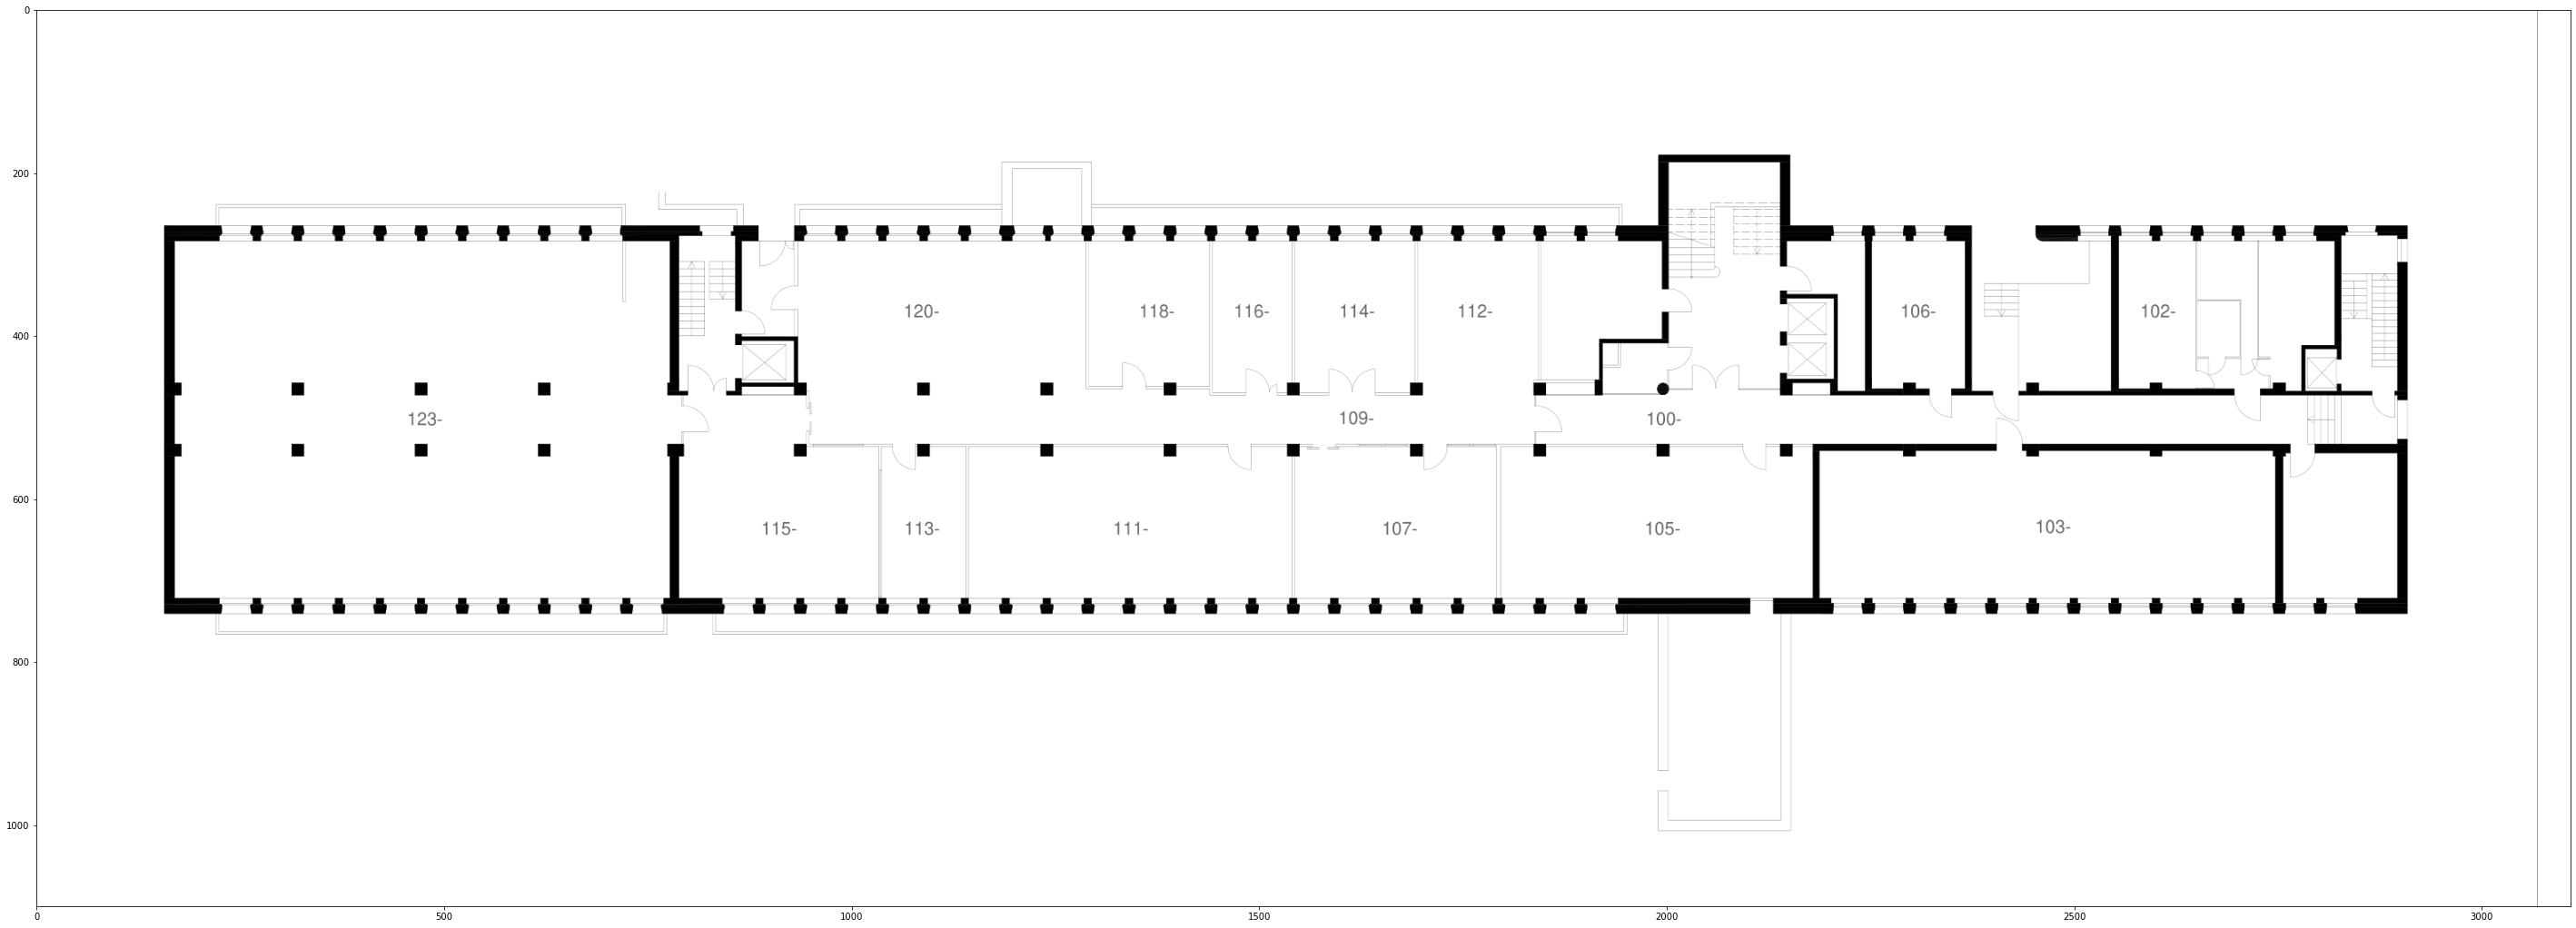

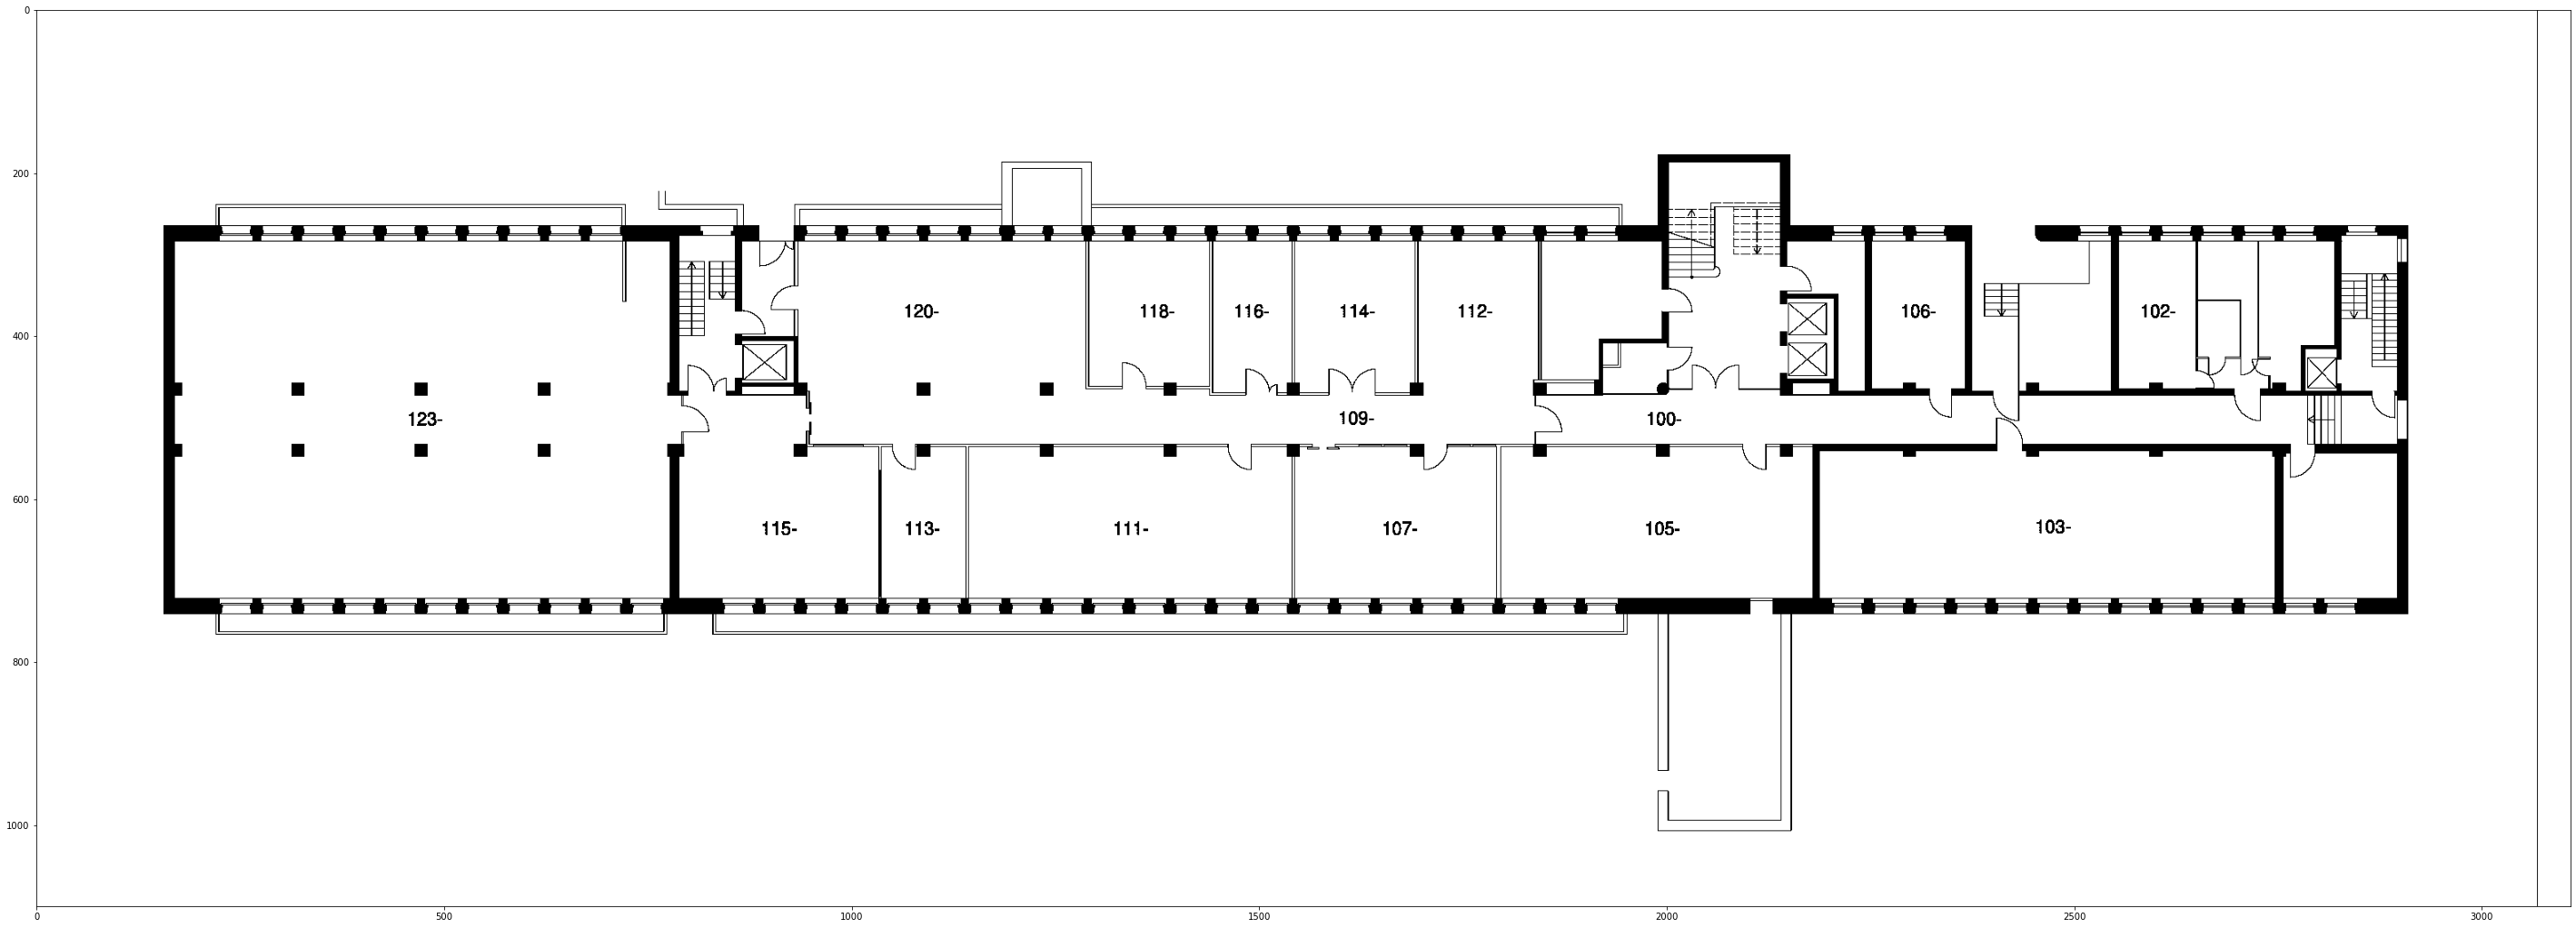

In [28]:
corners, img = cornerHarris(img_file)

In [88]:



def find_rooms(img, noise_removal_threshold=25, corners_threshold=0.1,
               room_closing_max_length=100, gap_in_wall_threshold=500, show=True):
    """

    :param img: grey scale image of rooms, already eroded and doors removed etc.
    :param noise_removal_threshold: Minimal area of blobs to be kept.
    :param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    :param room_closing_max_length: Maximum line length to add to close off open doors.
    :param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    :return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal

    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop = img[600:1700,200:3400]
    img = img_gen_crop
    img = np.where(img > 250, 255, 0).astype(np.uint8)
    contours = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    mask = np.zeros_like(img)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)

    img = ~mask
    if show:
        plt.imshow(img, cmap="gray")
    # Detect corners (you can play with the parameters here)
    dst = cv2.cornerHarris(img ,2, 3, 0.04)
    dst = cv2.dilate(dst,None)
    corners = dst > corners_threshold * dst.max()

    # Draw lines to close the rooms off by adding a line between corners on the same x or y coordinate
    # This gets some false positives.
    # You could try to disallow drawing through other existing lines for example.
    for y,row in enumerate(corners):
        x_same_y = np.argwhere(row)
        print("hi")
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):

            if x2[0] - x1[0] < room_closing_max_length:
                color = np.array([0,0,0])
                img = cv2.line(img, (x1, y), (x2, y), color, 2).astype(np.uint8)

    for x,col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if y2[0] - y1[0] < room_closing_max_length:
                color = np.array([0,0,0])
                img = cv2.line(img, (x, y1), (x, y2), color, 2).astype(np.uint8)


    # Mark the outside of the house as black
    contours = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(mask)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 0

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if img[component].sum() == 0 or np.count_nonzero(component) < gap_in_wall_threshold:
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 255, size=3)
        img[component] = color

    return rooms, img


hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type


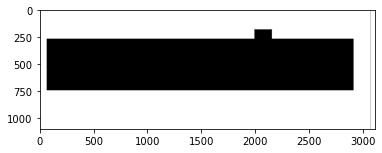

In [77]:

rooms, colored_house = find_rooms(img_new.copy())
plt.imshow('result', colored_house)